In [1]:
import os
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import random
import glob
import nibabel as nib
import numpy as np
from scipy.ndimage import rotate
import csv
import SimpleITK as sitk
from lungtumormask import mask as tumormask
from lungmask import mask as lungmask_fun

from monai.utils import first, set_determinism
from monai.transforms import (
    RandFlipd,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    FillHoles,
    RemoveSmallObjects,
    KeepLargestConnectedComponent,
    RandCropByPosNegLabeld,
    SaveImaged,
    CenterSpatialCropd,
    SpatialCropd,
    ScaleIntensityRanged,
    Spacingd,
    AsDiscrete,
    SpatialCrop,
    RandSpatialCropd,
    SpatialPadd,
    EnsureTyped,
    EnsureType,
    Invertd,
    DivisiblePadd,
    MapTransform,
    RandWeightedCropd,
    ToTensord,
    Transpose,
    ToTensor,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet,VNet,SwinUNETR,UNETR,DynUNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric,SurfaceDiceMetric,SurfaceDistanceMetric,HausdorffDistanceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch,pad_list_data_collate
from monai.config import print_config
from monai.apps import download_and_extract

/home/umcg/Desktop/AutomaticITV_code/Aitv_envV0/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)


if False:
    %matplotlib inline

device: cuda


In [3]:
#peregrine
#root_path = '/data/p308104/NBIA_Data/NIFTI_NBIA/imagesTr/'
#root_path = '/data/p308104/Nifti_Imgs_V0/' #UMCG data on peregrine
#local
#root_path = '/home/umcg/Desktop/NBIA/NBIA_Nifti_v0/imagesTr/'
#root_path = '/home/umcg/Desktop/Dicom_UMCG/MultipleBP/' 
#root_path = '/home/umcg/OneDrive/MultipleBreathingP/'
root_path = '/home/umcg/Desktop/AutomaticITV_code/MultipleBreathingP-OneDriveCopy/MultipleBreathingP/'


all_patientdir = []
all_patientdir = os.listdir(root_path)
all_patientdir.sort()
print(len(all_patientdir))


214


In [4]:
list_PxOk = []
list_PxNOTOk = []
CT_fpaths = []
lbl_fpaths= []
lung_fpaths = []
predicted_fpaths = []
for patient_path in all_patientdir:
    flag_PxOk=0
    ct_miss = True
    lung_miss = True
    gtv_miss = True
    predicted_miss=True
    for root, dirs, files in os.walk(root_path+patient_path, topdown=False):   
        for f in files:
            if "50%_ct.nii.gz" in f.lower() and ct_miss:
                CT_fpaths.append(os.path.join(root_path,patient_path,f))
                flag_PxOk+=1
                ct_miss = False
            if "ex_ct.nii.gz" in f.lower() and ct_miss:
                CT_fpaths.append(os.path.join(root_path,patient_path,f))
                flag_PxOk+=1
                ct_miss = False
            if "in_ct.nii.gz" in f.lower() and ct_miss:
                CT_fpaths.append(os.path.join(root_path,patient_path,f))
                flag_PxOk+=1
                ct_miss = False
            if "mar_ct.nii.gz" in f.lower() and ct_miss:
                CT_fpaths.append(os.path.join(root_path,patient_path,f))
                flag_PxOk+=1
                ct_miss = False
            if "gtv.nii.gz" in f.lower():
                lbl_fpaths.append(os.path.join(root_path,patient_path,f))
                flag_PxOk+=1
                gtv_miss =False
            if ("50%_lungmask.nii.gz" in f.lower()) and lung_miss:
                lung_fpaths.append(os.path.join(root_path,patient_path,f))
                lung_miss = False
                flag_PxOk+=1
            if ("ex_lungmask.nii.gz" in f.lower()) and lung_miss:
                lung_fpaths.append(os.path.join(root_path,patient_path,f))
                flag_PxOk+=1
                lung_miss = False
            if ("in_lungmask.nii.gz" in f.lower()) and lung_miss:
                lung_fpaths.append(os.path.join(root_path,patient_path,f))
                flag_PxOk+=1
                lung_miss = False
            if ("mar_lungmask.nii.gz" in f.lower()) and lung_miss:
                lung_fpaths.append(os.path.join(root_path,patient_path,f))
                flag_PxOk+=1
                lung_miss = False
            if ("predictedts_v0.nii.gz" in f.lower()) and predicted_miss:
                predicted_fpaths.append(os.path.join(root_path,patient_path,f))
                flag_PxOk+=1
                predicted_miss = False

        if flag_PxOk!=4:
            list_PxNOTOk.append(patient_path)
            if ct_miss==False:
                print(patient_path,flag_PxOk,'GTV Miss: ',gtv_miss,'CT miss: ',ct_miss)
                CT_fpaths = CT_fpaths[:-1]
                lung_fpaths =lung_fpaths[:-1] 
        else:
            list_PxOk.append(patient_path)
                
    

print(len(CT_fpaths),len(lbl_fpaths),len(lung_fpaths),len(predicted_fpaths))
CT_fpaths.sort()
lbl_fpaths.sort()
lung_fpaths.sort()

print(CT_fpaths[44])
print(lbl_fpaths[44])
print(lung_fpaths[44])
print(predicted_fpaths[44])

0681787 2 GTV Miss:  True CT miss:  False
1085623 2 GTV Miss:  True CT miss:  False
1217944 2 GTV Miss:  True CT miss:  False
1335112 2 GTV Miss:  True CT miss:  False
1407694 2 GTV Miss:  True CT miss:  False
1512417 2 GTV Miss:  True CT miss:  False
1691410 2 GTV Miss:  True CT miss:  False
1889844 2 GTV Miss:  True CT miss:  False
2015331 2 GTV Miss:  True CT miss:  False
2062235 2 GTV Miss:  True CT miss:  False
2256336 2 GTV Miss:  True CT miss:  False
3166265 2 GTV Miss:  True CT miss:  False
3747620 2 GTV Miss:  True CT miss:  False
5735300 2 GTV Miss:  True CT miss:  False
190 190 190 190
/home/umcg/Desktop/AutomaticITV_code/MultipleBreathingP-OneDriveCopy/MultipleBreathingP/1372853/1372853_50%_ct.nii.gz
/home/umcg/Desktop/AutomaticITV_code/MultipleBreathingP-OneDriveCopy/MultipleBreathingP/1372853/1372853_rtstruct_GTV.nii.gz
/home/umcg/Desktop/AutomaticITV_code/MultipleBreathingP-OneDriveCopy/MultipleBreathingP/1372853/1372853_50%_LungMask.nii.gz
/home/umcg/Desktop/AutomaticIT

In [5]:
nii_img  = nib.load(CT_fpaths[44])
nii_data = nii_img.get_fdata()
print(nii_data.shape)
nii_img  = nib.load(lbl_fpaths[44])
nii_data = nii_img.get_fdata()
print(nii_data.shape)
nii_img  = nib.load(lung_fpaths[44])
nii_data = nii_img.get_fdata()
print(nii_data.shape)
nii_img  = nib.load(predicted_fpaths[44])
nii_data = nii_img.get_fdata()
print(nii_data.shape)

(512, 512, 262)
(512, 512, 262)
(262, 512, 512)
(512, 512, 262)


In [ ]:
# Save csv file of patients ok and px not ok 
if False:
    print('List Ok: ',len(list_PxOk),'List NOT Ok',len(list_PxNOTOk))
    file = open('ListPatientsStatus.csv', 'w')
    writer = csv.writer(file)
    writer.writerow(['Patients Ok'])
    writer.writerow(list_PxOk)
    writer.writerow(['Patients NOT Ok'])
    writer.writerow(list_PxNOTOk)
    file.close()

In [14]:
#Predicts both tumor and lung mask
Predict = False
if Predict:
    gtv = lbl_fpaths[0]
    gtv = nib.load(gtv)

    for ct in CT_fpaths:
        empty_header = nib.Nifti1Header()
        predicted_path = ct[:-7]+'_predictedTS_V0.nii.gz'
        if True: #Get Tumor mask
            tumormask.mask(ct, predicted_path)
        if False: #Get Lung mask and save it
            lung_path = ct[:-10]+'_LungMask.nii.gz'
            input_image = sitk.ReadImage(ct, imageIO='NiftiImageIO')
            lungmask = lungmask_fun.apply(input_image)  # default model is U-net(R231)
            lungmask_ni = nib.Nifti1Image(lungmask, gtv.affine,empty_header)
            nib.save(lungmask_ni,lung_path)

In [6]:
#Check max min tumor values
if False :
    minmin = 100
    maxmax = 0
    for i in range(len(data_dicts)):
        img = nib.load(data_dicts[i]["predicted"])
        data_img = img.get_fdata()
        #data_img = np.transpose(data_img, (1,2,0))# fix misshape 
        if False:
            for j in range(data_img.shape[2]):
                if np.sum(data_img[:,:,j])>0:
                    plt.imshow(data_img[:,:,j])
                    plt.show()
        #break
        if np.min(data_img) < minmin:
            minmin = np.min(data_img)
        if np.max(data_img) > maxmax:
            maxmax = np.max(data_img)

    print("minmin: ",minmin,"maxmax: ", maxmax)


In [7]:
#Create data dictionat
data_dicts = [
    {"image": image_name,"lung":lung_name,"label": label_name,"predicted":predicted_name}
    for image_name,lung_name,label_name,predicted_name in zip(CT_fpaths,lung_fpaths,lbl_fpaths,predicted_fpaths)
]
train_files, val_files = data_dicts[:-100], data_dicts[-100:]
print('train val len:',len(train_files),'-',len(val_files))

minmin_CT = -1024 #NBIA
maxmax_CT = 3071 #NBIA

train val len: 90 - 100


In [8]:
#class to transpose lung mask
class Create_sequences(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)
        
        print(f"keys to transpose: {self.keys}")

         
    def __call__(self, dictionary):
        dictionary = dict(dictionary)
        for key in self.keys:
            data = dictionary[key]
            if key == 'lung':
                data = np.transpose(data, (0,2,3,1))
                data = rotate(data,270,axes=(1,2),reshape=False)
                data = np.flip(data,1)
                data[data==2] = int(1)
                data[data!=1] = int(0)
            dictionary[key] = data
        
        for key in self.keys:
            data = dictionary[key]
            if key == 'predicted':
                #data = np.transpose(data, (0,2,3,1))
                data = rotate(data,180,axes=(1,2),reshape=False)
                #data = np.flip(data,1)
                data[data==2] = int(1)
                data[data!=1] = int(0)
            dictionary[key] = data
        
        return dictionary        

In [9]:
#Create Compose functions for preprocessing of train and validation
set_determinism(seed=0)
image_keys = ["image","lung","label","predicted"]
p = .5 #Data aug transform probability
size = 96
image_size = (size,size,size)
train_transforms = Compose(
    [
        LoadImaged(keys=image_keys),
        EnsureChannelFirstd(keys=image_keys),
        Orientationd(keys=["image","label"], axcodes="RAS"),
        #Spacingd(keys=["image","label"], pixdim=(1,1,1),mode=("bilinear","nearest")),
        ScaleIntensityRanged(keys=["image"], a_min=minmin_CT, a_max=maxmax_CT,b_min=0.0, b_max=1.0, clip=True,),
        Create_sequences(keys=image_keys),
        CropForegroundd(keys=image_keys, source_key="lung",k_divisible = size),
        RandCropByPosNegLabeld(
            keys=image_keys,label_key='label',spatial_size=image_size,pos=1,neg=1,num_samples=2,
            image_key='image',image_threshold=0,),
        #RandFlipd(keys=image_keys,spatial_axis=[0],prob=p / 3,),
        #RandFlipd(keys=image_keys,spatial_axis=[1],prob=p / 3,),
        #RandFlipd(keys=image_keys,spatial_axis=[2],prob=p / 3,),
        ToTensord(keys=image_keys),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=image_keys),
        EnsureChannelFirstd(keys=image_keys),
        Orientationd(keys=["image","label"], axcodes="RAS"),
        #Spacingd(keys=["image","label"], pixdim=(1,1,1),mode=("bilinear","nearest")),
        ScaleIntensityRanged(keys=["image"], a_min=minmin_CT, a_max=maxmax_CT,b_min=0.0, b_max=1.0, clip=True,),
        Create_sequences(keys=image_keys),
        CropForegroundd(keys=image_keys, source_key="lung",k_divisible = size),
        ToTensord(keys=image_keys),
    ]
)


keys to transpose: ('image', 'lung', 'label', 'predicted')
keys to transpose: ('image', 'lung', 'label', 'predicted')


In [10]:
#Check the images after the preprocessing
if True:
    check_ds =Dataset(data=val_files, transform=val_transforms)
    check_loader = DataLoader(check_ds, batch_size=1,num_workers=0)
    if False:
        count = 1
        for batch_data in check_loader:
            #batch_data = first(check_loader)
            image,lung, label,predicted = (batch_data["image"][0][0],batch_data["lung"][0][0],batch_data["label"][0][0],batch_data["predicted"][0][0])
            print(f"px info:{count },image shape: {image.shape},lung shape: {lung.shape}, label shape: {label.shape}")
            count+=1
            for i in range(label.shape[2]):
                if torch.sum(label[:,:,i])>0:
                    plt.subplot(1,3,1),plt.imshow(image[:,:,i]),plt.axis('off')
                    plt.subplot(1,3,2),plt.imshow(predicted[:,:,i]+image[:,:,i]),plt.axis('off')
                    plt.subplot(1,3,3),plt.imshow(label[:,:,i]+image[:,:,i]),plt.axis('off')
                    count+=1
                    plt.tight_layout(),plt.show()
                    break
            if count>20:
                break

In [ ]:
#Get the dataset ready for the model
if False:
    train_ds = Dataset(data=train_files, transform=train_transforms)
    train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0)

    val_ds = Dataset(data=val_files, transform=val_transforms)
    val_loader = DataLoader(val_ds, batch_size=1, num_workers=0)#,collate_fn=pad_list_data_collate)

In [61]:
#Create the model
spatial_dims = 3
max_epochs = 100
in_channels = 1
out_channels=2 #including background
if True:
    model = SwinUNETR(
        image_size, 
        in_channels, out_channels, 
        use_checkpoint=True, 
        feature_size=24,
        #spatial_dims=spatial_dims
    ).to(device)
else:
    model = UNet(
        spatial_dims=spatial_dims,
        in_channels=in_channels,
        out_channels=out_channels,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=4,
        norm=Norm.BATCH,
    ).to(device)

#metrics
loss_function = DiceLoss(to_onehot_y=True, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=True, reduction="mean")
surfDice_metric = SurfaceDiceMetric([0.01,0.01],include_background=True)
surfDice_metric_1Class = SurfaceDiceMetric([10],include_background=False)
hausdorff_metric = HausdorffDistanceMetric(include_background=True, reduction="mean")

In [12]:
# Load pretrained model
pretrained_path = '/home/umcg/Desktop/AutomaticITV_code/weights/best_m_MONAI_V3_NBIAWeightsretrainedWithUMCGdata.pth'

if pretrained_path is not(None):
    model.load_state_dict(torch.load(pretrained_path, map_location=torch.device(device)))

    #weight = torch.load(pretrained_path, map_location=torch.device(device))
    #model.load_from(weights=weight)
    print('Using pretrained weights!')

Using pretrained weights!


In [153]:
post_transforms = Compose(
    [
        EnsureType(),
        AsDiscrete(argmax=False,to_onehot=out_channels, threshold=.1),
        FillHoles(applied_labels=1, connectivity=0),
        RemoveSmallObjects(min_size=5, connectivity=3, independent_channels=True),
        #KeepLargestConnectedComponent(applied_labels=None,is_onehot=True,connectivity=3, num_components=3),
    ]
)

post_pred = Compose([EnsureType(), AsDiscrete(argmax=True,threshold=0.5)])
post_label = Compose([EnsureType(), AsDiscrete(threshold=0.5)],)


(1, 384, 288, 192) (1, 384, 288, 192) (1, 384, 288, 192)


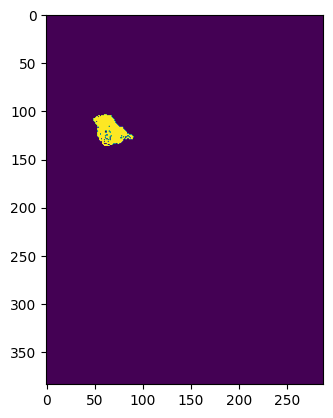

In [155]:
postImg_monai = [post_transforms(i) for i in decollate_batch(val_predicted)]
print(val_outputs[0].shape,val_labels[0].shape,postImg_monai[0][1:,:,:,:].shape)
plt.imshow(postImg_monai[0][1,:,:,105].cpu())
plt.show()


In [101]:
#compute metric for current iteration
#Batch x Channel x Height x Width - [B,C,H,W] - 1, 384, 288, 192
#Channel is number of classes
def surfDiceFun(val_labels,postImg_monai):
    ylabe_BCHW_neg = val_labels[0].cpu().numpy()
    ylabe_BCHW_neg = ylabe_BCHW_neg*-1+1
    ylabe_BCHW_pos = val_labels[0].cpu().numpy()
    ylabe_BCHW = np.concatenate((ylabe_BCHW_neg, ylabe_BCHW_pos),0)
    transpose_monai = Compose([Transpose([3, 0, 1, 2])])
    ylabe_BCHW = transpose_monai(ylabe_BCHW)
    ypred_BCHW = postImg_monai[0].permute(3, 0, 1, 2)

    list_surf=[]
    for i in range(ypred_BCHW.shape[0]-4):
        surfDice_metric(y_pred=ypred_BCHW[i:i+2,:,:,:], y=ylabe_BCHW[i:i+2,:,:,:])
        #print('SurfFice monai    :',surfDice_metric.aggregate().item())
        list_surf.append(surfDice_metric.aggregate().item())
        surfDice_metric.reset()
    return np.mean(list_surf)

def surfDiceFun_1Class(val_labels,postImg_monai):
    ylabe_BCHW_neg = val_labels[0].cpu().numpy()
    ylabe_BCHW_neg = ylabe_BCHW_neg*-1+1
    ylabe_BCHW_pos = val_labels[0].cpu().numpy()
    ylabe_BCHW = np.concatenate((ylabe_BCHW_neg, ylabe_BCHW_pos),0)
    transpose_monai = Compose([Transpose([3, 0, 1, 2])])
    ylabe_BCHW = transpose_monai(ylabe_BCHW)
    ypred_BCHW = postImg_monai[0].permute(3, 0, 1, 2)
    
    #print(ypred_BCHW.shape,ylabe_BCHW.shape)
    list_surf=[]
    for i in range(ypred_BCHW.shape[0]-4):
        if  np.sum(ylabe_BCHW[i:i+2,1,:,:])>0:# or np.sum(ypred_BCHW[i:i+2,0,:,:])>0:
            surfDice_metric_1Class(y_pred=ypred_BCHW[i:i+2,:,:,:], y=ylabe_BCHW[i:i+2,0:,:,:])
            list_surf.append(surfDice_metric_1Class.aggregate().item())
            #print(list_surf[-1])
            surfDice_metric_1Class.reset()
    return np.mean(list_surf)
#hausdorff_metric(y_pred=postImg_monai, y=val_labels)
#print('hausdorff monai    :',hausdorff_metric.aggregate().item())
#hausdorff_metric.reset()

Scores vanilla: 0.7467749714851379
Scores monai    : 0.7558179497718811
SurfFice vanilla 1 class: 0.8963616121177994
SurfFice monai 1 class: 0.896122221322523


read
Scores vanilla: 0.7467749714851379
Scores monai    : 0.7558179497718811
SurfFice vanilla 1 class: 0.8963616121177994
SurfFice monai 1 class: 0.896122221322523
read
Scores vanilla: 0.608893632888794
Scores monai    : 0.6121390461921692
SurfFice vanilla 1 class: 0.9411908870552795
SurfFice monai 1 class: 0.9403831666075043
read
Scores vanilla: 0.3455255925655365
Scores monai    : 0.34581902623176575
SurfFice vanilla 1 class: 0.591485654959039
SurfFice monai 1 class: 0.5931539862232931
read
Scores vanilla: 0.5905037522315979
Scores monai    : 0.6001583933830261
SurfFice vanilla 1 class: 0.7917185015793006
SurfFice monai 1 class: 0.7840888550977592
read
Scores vanilla: 0.42822614312171936
Scores monai    : 0.42800694704055786
SurfFice vanilla 1 class: 0.8471593765711414
SurfFice monai 1 class: 0.8471593765711414
read
Scores vanilla: 0.5683106780052185
Scores monai    : 0.5698136687278748
SurfFice vanilla 1 class: 0.9583333333333334
SurfFice monai 1 class: 0.9583333333333334
read
Score

/tmp/ipykernel_10117/229868455.py:43: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, nr_images, j),plt.title('CT ({})'.format(idx)),plt.imshow(val_inputs.cpu().numpy()[instance, 0, :, :, idx], cmap='gray', vmin=0, vmax=1),plt.axis('off')
/tmp/ipykernel_10117/229868455.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, nr_images, nr_images+j),plt.title('GTV ({})'.format(idx)),plt.imshow(val_labels.cpu().numpy()[instance, 0, :, :, idx]),plt.axis('off')
/tmp/ipykernel_10117/229868455.py:45: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, nr_images, 2*nr_images+j),plt.t

Scores vanilla: 0.7277758717536926
Scores monai    : 0.7372936606407166
SurfFice vanilla 1 class: 0.8698540315266534
SurfFice monai 1 class: 0.8744712167278768
read
Scores vanilla: 0.3623643219470978
Scores monai    : 0.36342328786849976
SurfFice vanilla 1 class: 0.5031881256265486
SurfFice monai 1 class: 0.5031647772973321
read
Scores vanilla: 0.0
Scores monai    : 0.0
SurfFice vanilla 1 class: 0.0
SurfFice monai 1 class: 0.0
read
Scores vanilla: 0.7272466421127319
Scores monai    : 0.7324790954589844
SurfFice vanilla 1 class: 0.30839183266082604
SurfFice monai 1 class: 0.36323402410055905
read
Scores vanilla: 0.5816033482551575
Scores monai    : 0.5906349420547485
SurfFice vanilla 1 class: 0.4803185167986726
SurfFice monai 1 class: 0.4927008912651948
read
Scores vanilla: 0.01606961525976658
Scores monai    : 0.015674784779548645
SurfFice vanilla 1 class: 0.07863844779450815
SurfFice monai 1 class: 0.08164854147708582
read
Scores vanilla: 0.5178501605987549
Scores monai    : 0.5195891

SurfFice vanilla 1 class: 0.14285714285714285
SurfFice monai 1 class: 0.14285714285714285
read
Scores vanilla: 0.20556116104125977
Scores monai    : 0.20556116104125977
SurfFice vanilla 1 class: 0.5
SurfFice monai 1 class: 0.5
read
Scores vanilla: 0.0
Scores monai    : 0.0
SurfFice vanilla 1 class: 0.0
SurfFice monai 1 class: 0.0
read
Scores vanilla: 0.5268334150314331
Scores monai    : 0.527953028678894
SurfFice vanilla 1 class: 0.2471765391025323
SurfFice monai 1 class: 0.288506958909186
read
Scores vanilla: 0.6627237796783447
Scores monai    : 0.6664018034934998
SurfFice vanilla 1 class: 0.8616477114977865
SurfFice monai 1 class: 0.8615755614256364
read
Scores vanilla: 0.6613564491271973
Scores monai    : 0.6620593070983887
SurfFice vanilla 1 class: 0.4734304967746365
SurfFice monai 1 class: 0.48360347008813914
read
Scores vanilla: 0.5677508115768433
Scores monai    : 0.5724105834960938
SurfFice vanilla 1 class: 0.9203254117180854
SurfFice monai 1 class: 0.9203254117180854
read
Scor

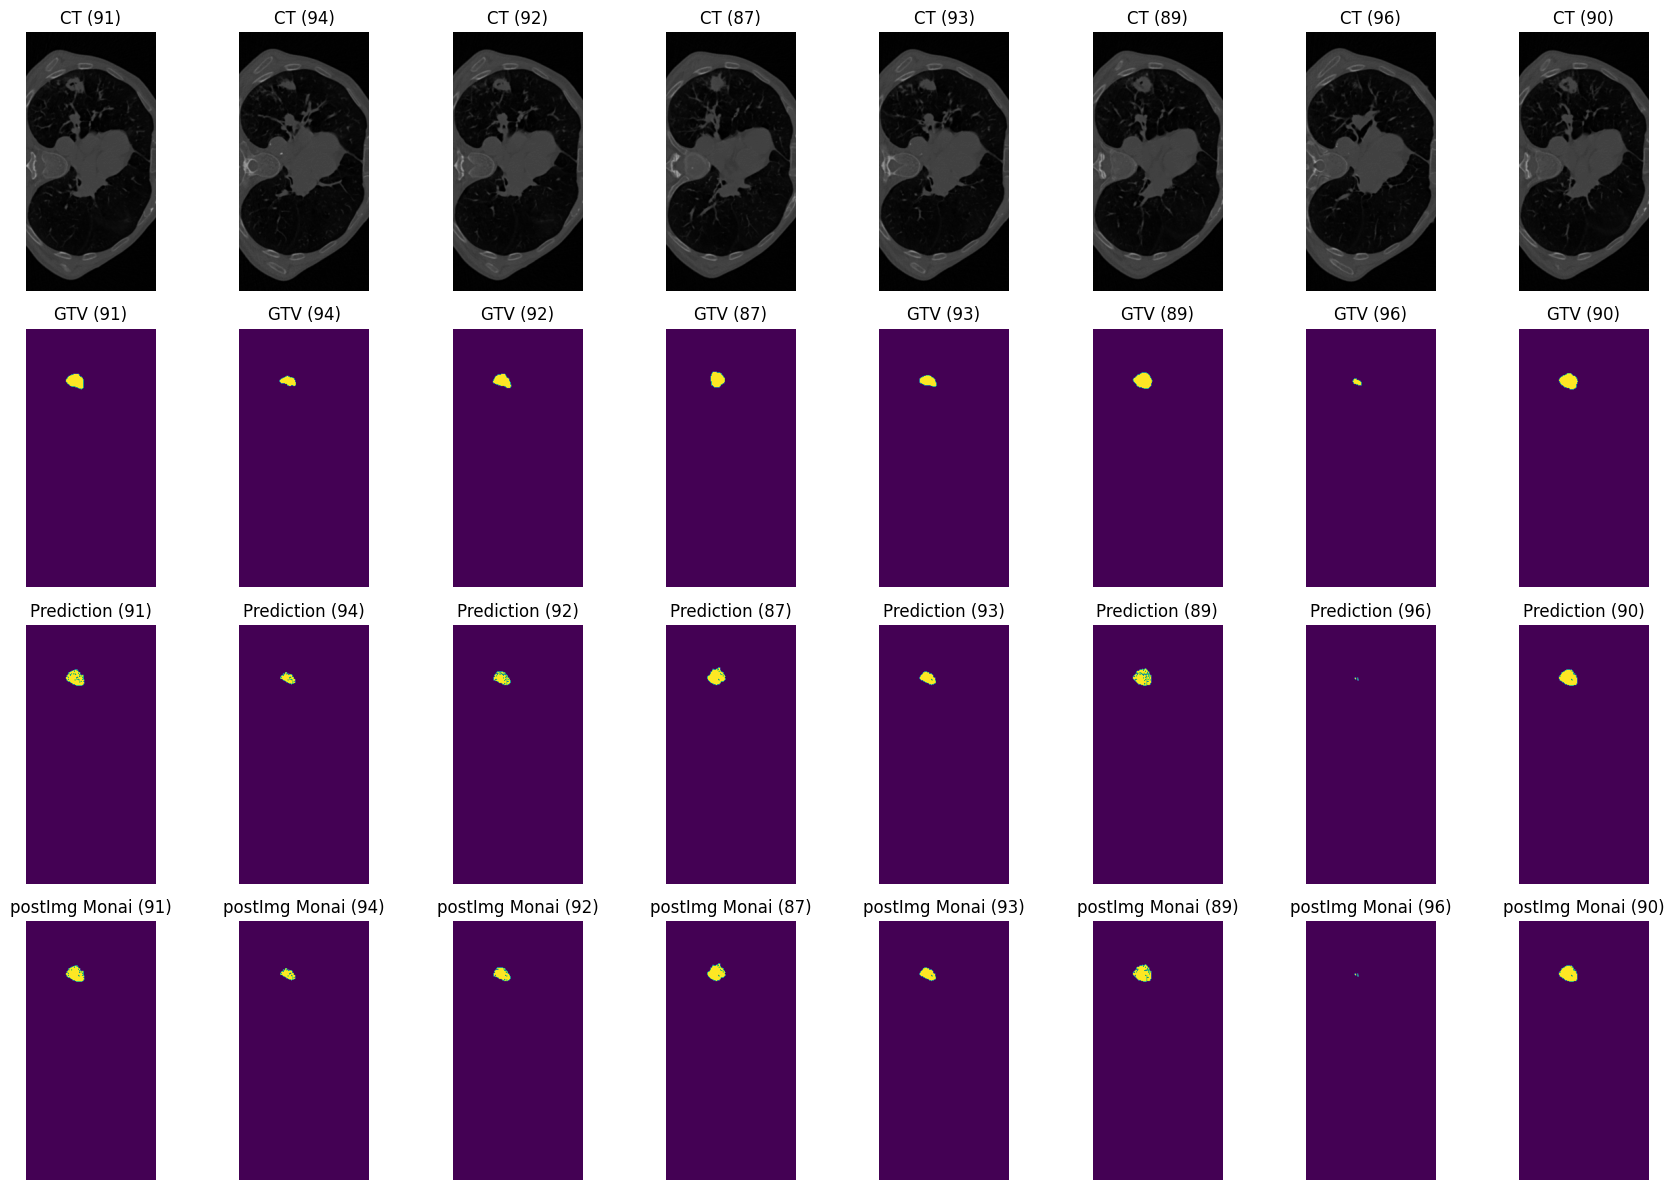

In [159]:
#Testing the model
count=0
nr_images=8
figsize = (18, 12)
#figures_folder_i = '/data/p308104/NBIA_Data/NIFTI_NBIA/Res-16092022/' #Peregrine
figures_folder_i ='/home/umcg/Desktop/AutomaticITV_code/figures_folder_TumorMask/' #Local
all_metrics = []
model.eval()
with torch.no_grad():
    for val_data in check_loader:
        val_inputs, val_labels,val_predicted = (
            val_data["image"].to(device),
            val_data["label"].to(device),
            val_data["predicted"].to(device),
        )
        roi_size = image_size
        sw_batch_size = 1
        
        #val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        val_outputs = val_predicted
        
        #postImg_manual  = PostProcessing(val_outputs.cpu())
        #postImg_manual  = [post_transforms(i) for i in decollate_batch(postImg_manual)]
        postImg_monai = [post_transforms(i) for i in decollate_batch(val_predicted)]        
        print('read')
        if True: #True if plot
            # Determine slices to be plotted
            # Make sure that nr_images that we want to plot is greater than or equal to the number of slices available
            slice_indices = []
            for i in range(val_inputs.shape[4]):
                if np.sum(val_labels.cpu().numpy()[0, 0, :, :, i])>0:
                    slice_indices.append(i)
            if len(slice_indices) <nr_images:
                slice_indices.append(random.sample(range(1, 95),nr_images-len(slice_indices))[0])
            else:
                slice_indices = random.sample(slice_indices, k=nr_images)
            instance = random.randint(0, val_inputs.shape[0] - 1)
            j = 1
            px = val_files[count]['label'].split('/')[-2]
            for i, idx in enumerate(slice_indices):
                j=1+i
                fig = plt.figure('Instance = {}'.format(instance), figsize=figsize)
                plt.subplot(4, nr_images, j),plt.title('CT ({})'.format(idx)),plt.imshow(val_inputs.cpu().numpy()[instance, 0, :, :, idx], cmap='gray', vmin=0, vmax=1),plt.axis('off')
                plt.subplot(4, nr_images, nr_images+j),plt.title('GTV ({})'.format(idx)),plt.imshow(val_labels.cpu().numpy()[instance, 0, :, :, idx]),plt.axis('off')
                plt.subplot(4, nr_images, 2*nr_images+j),plt.title('Prediction ({})'.format(idx)),plt.imshow(val_outputs.cpu().numpy()[instance, 0, :, :, idx]),plt.axis('off')
                #plt.subplot(4, nr_images, 2*nr_images+j),plt.title('Prediction ({})'.format(idx)),plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[instance, :, :, idx]),plt.axis('off')
                #plt.subplot(5, nr_images, j),plt.title('postImg Manual ({})'.format(idx)),plt.imshow(postImg_manual[0].detach().cpu()[instance, :, :, idx]),plt.axis('off')
                plt.subplot(4, nr_images, 3*nr_images+j),plt.title('postImg Monai ({})'.format(idx)),plt.imshow(postImg_monai[0].detach().cpu()[1, :, :, idx]),plt.axis('off')
            plt.tight_layout()
            plt.savefig(os.path.join(figures_folder_i,'final_{}.png'.format(px)))
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(val_labels)]

        #compute metric for current iteration
        #compute metric for current iteration
        dice_metric(y_pred=val_predicted[0], y=val_labels[0])
        dice0 = dice_metric.aggregate().item()
        print('Scores vanilla:',dice0)
        dice_metric.reset()

        dice_metric(y_pred=postImg_monai[0][1:,:,:,:], y=val_labels[0])
        dice1 = dice_metric.aggregate().item()
        print('Scores monai    :',dice1)
        dice_metric.reset()
        sdice0 = surfDiceFun_1Class(val_labels,val_predicted)
        sdice1 = surfDiceFun_1Class(val_labels,postImg_monai)
        print('SurfFice vanilla 1 class:',sdice0)
        print('SurfFice monai 1 class:',sdice1)
        all_metrics.append([val_files[count]['label'].split('/')[-2],dice0,dice1,sdice0,sdice1])
        count+=1
        
#Save csv of metrics
if True: 
    f= open(figures_folder_i+'res_TumorMask.csv','w', encoding='UTF8')
    writer = csv.writer(f)
    writer.writerow(['Patient','Dice V','Dice P','Sdice V','SDice P'])
    writer.writerows(all_metrics)
    f.close()


In [ ]:
#Save csv of metrics
f= open(figures_folder_i+'res','w', encoding='UTF8')
writer = csv.writer(f)
writer.writerow(['Patient','Dice V','Dice P','Sdice V','SDice P'])
writer.writerows(all_metrics)
f.close()

In [ ]:
#Load csv of metrics

if False:
    import pandas as pd
    df = pd.read_csv(r'/home/umcg/Desktop/AutomaticITV_code/figures_folder_i/res.csv')
    print(df.mean())
    print(df.std())

In [ ]:
      hausdorff_metric(y_pred=postImg_monai, y=val_labels)
        print('hausdorff monai    :',hausdorff_metric.aggregate().item())
        hausdorff_metric.reset()

In [ ]:
from skimage.measure import label, regionprops
from skimage.morphology import dilation,disk,erosion
def PostProcessing(predicted):
    img = predicted
    for i in range(predicted.shape[-1]-10):
        j=i+5
        #Get imgs
        Before = predicted[0,1,:,:,j-1]
        Current = predicted[0,1,:,:,j]
        After = predicted[0,1,:,:,j+1]
        AAfter = predicted[0,1,:,:,j+2]+After
        AAfter = predicted[0,1,:,:,j+3]+AAfter
        AAfter = predicted[0,1,:,:,j+4]+AAfter
        AAfter = predicted[0,1,:,:,j+5]+AAfter
        BBefore = predicted[0,1,:,:,j-2]+Before
        BBefore = predicted[0,1,:,:,j-3]+BBefore
        BBefore = predicted[0,1,:,:,j-4]+BBefore
        BBefore = predicted[0,1,:,:,j-5]+BBefore
        
        #Binarize
        t = .5
        BBefore[BBefore>=t] =int(1)
        BBefore[BBefore<t] =int(0)
        Current[Current>=t] =int(1)
        Current[Current<t] =int(0)
        AAfter[AAfter>=t] =int(1)
        AAfter[AAfter<t] =int(0)
        
        #Morphology
        m = 15
        BBefore = dilation(BBefore, disk(m))
        Current = dilation(Current, disk(m))
        AAfter = dilation(AAfter, disk(m))
        m = 5
        BBefore = erosion(BBefore, disk(m))
        Current = erosion(Current, disk(m))
        AAfter = erosion(AAfter, disk(m))
        
        #And Between slices -> <- ... for missing 
        ABS = np.logical_and(BBefore,AAfter)
        Current = np.logical_or(ABS,Current)
        
        #And outside slices <-->  ... for false positives with RegionProps
        BBefore_label = label(BBefore)
        Current_label = label(Current)
        AAfter_label = label(AAfter)
        BBefore_regions = regionprops(BBefore_label)
        Current_regions = regionprops(Current_label)
        AAfter_regions = regionprops(AAfter_label)
        #Look for centroids distance
        limit =  20
        if False:
            for c_centroid in Current_regions:
                for b_centroid in BBefore_regions:
                    dif = np.abs(np.asarray(c_centroid['centroid'])-np.asarray(b_centroid['centroid']))
                    if dif[0] > limit or dif[1] > limit: 
                        Current[Current==c_centroid['label']] = int(0)
                        print('delete blob')
                for a_centroid in AAfter_regions:
                    dif = np.abs(np.asarray(c_centroid['centroid'])-np.asarray(a_centroid['centroid']))
                    if dif[0] > limit or dif[1] > limit: 
                        Current[Current==c_centroid['label']] = int(0)
                        print('delete blob')
        if False:
            plt.subplot(1,4,1),plt.imshow(BBefore,cmap='gray', vmin=0, vmax=1)
            plt.subplot(1,4,2),plt.imshow(Current,cmap='gray', vmin=0, vmax=1)
            plt.subplot(1,4,3),plt.imshow(predicted[0,1,:,:,j],cmap='gray', vmin=0, vmax=1)
            plt.subplot(1,4,4),plt.imshow(AAfter,cmap='gray', vmin=0, vmax=1)
            plt.show()
    
        img[0,0,:,:,j] = torch.from_numpy(Current)
    return img

